ECE 9063 Data Analytics Project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import IPython

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from joblib import dump, load

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set Random Seeds

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Importing Data

In [3]:
# ============== Importing data ======================
featureFile = '2020.3-weather.csv'
featureData = pd.read_csv(featureFile)

labelFile = '2020.3-usage.csv'
labelData = pd.read_csv(labelFile)

# put feature and label in one object
data = pd.concat([featureData, labelData['Usage (kilowatt-hours)']], axis=1)
data

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Usage (kilowatt-hours)
0,-81.15,43.03,LONDON A,6144473,2020-03-01 00:00,2020,3,1,00:00,-9.9,NaN,-12.3,NaN,83,NaN,23.0,NaN,12,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-16.0,NaN,NaN,0.89
1,-81.15,43.03,LONDON A,6144473,2020-03-01 01:00,2020,3,1,01:00,-7.0,NaN,-11.0,NaN,73,NaN,25.0,NaN,11,NaN,24.1,NaN,98.54,NaN,NaN,NaN,-12.0,NaN,Clear,0.93
2,-81.15,43.03,LONDON A,6144473,2020-03-01 02:00,2020,3,1,02:00,-7.6,NaN,-11.3,NaN,75,NaN,26.0,NaN,10,NaN,24.1,NaN,98.57,NaN,NaN,NaN,-12.0,NaN,NaN,0.88
3,-81.15,43.03,LONDON A,6144473,2020-03-01 03:00,2020,3,1,03:00,-7.9,NaN,-11.0,NaN,79,NaN,25.0,NaN,10,NaN,24.1,NaN,98.60,NaN,NaN,NaN,-13.0,NaN,NaN,0.90
4,-81.15,43.03,LONDON A,6144473,2020-03-01 04:00,2020,3,1,04:00,-9.4,NaN,-11.5,NaN,85,NaN,26.0,NaN,7,NaN,24.1,NaN,98.63,NaN,NaN,NaN,-13.0,NaN,Clear,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,-81.15,43.03,LONDON A,6144473,2020-06-30 19:00,2020,6,30,19:00,26.8,NaN,14.1,NaN,45,NaN,12.0,NaN,8,NaN,24.1,NaN,98.17,NaN,30.0,NaN,NaN,NaN,Mainly Clear,3.81
2924,-81.15,43.03,LONDON A,6144473,2020-06-30 20:00,2020,6,30,20:00,24.4,NaN,15.7,NaN,58,NaN,17.0,NaN,6,NaN,24.1,NaN,98.20,NaN,29.0,NaN,NaN,NaN,NaN,4.64
2925,-81.15,43.03,LONDON A,6144473,2020-06-30 21:00,2020,6,30,21:00,21.4,NaN,16.3,NaN,72,NaN,9.0,NaN,5,NaN,24.1,NaN,98.25,NaN,26.0,NaN,NaN,NaN,NaN,7.89
2926,-81.15,43.03,LONDON A,6144473,2020-06-30 22:00,2020,6,30,22:00,21.2,NaN,16.8,NaN,76,NaN,23.0,NaN,7,NaN,24.1,NaN,98.28,NaN,26.0,NaN,NaN,NaN,Mainly Clear,4.49


Data Cleaning

In [4]:
# ================= Data Cleaning =======================

# drop the columns with mostly missing values
data = data.drop(columns=["Temp Flag", "Dew Point Temp Flag", "Rel Hum Flag", "Wind Dir Flag", "Wind Spd Flag",
                   "Visibility Flag", "Stn Press Flag", "Hmdx", "Hmdx Flag", "Wind Chill", "Wind Chill Flag"])

# drop columns with constant data
data = data.drop(columns=["Longitude (x)", "Latitude (y)", "Station Name", "Climate ID", 'Date/Time'])

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    1
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           2
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   1610
Usage (kilowatt-hours)       0
dtype: int64


In [5]:
# Deal with missing values
columns_to_clean = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
                    "Visibility (km)", "Stn Press (kPa)"]

# replace with previous hour data
for col in columns_to_clean:
    data[col].fillna(method='ffill', inplace=True)
    
print(data.isnull().sum())


Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   1610
Usage (kilowatt-hours)       0
dtype: int64


Weather Attribute

In [6]:
# clean the "weather" attribute: replace missing values with previous observations
data["Weather"].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)                 0
Dew Point Temp (°C)       0
Rel Hum (%)               0
Wind Dir (10s deg)        0
Wind Spd (km/h)           0
Visibility (km)           0
Stn Press (kPa)           0
Weather                   1
Usage (kilowatt-hours)    0
dtype: int64


Exploratory Data Analysis

<Figure size 720x360 with 0 Axes>

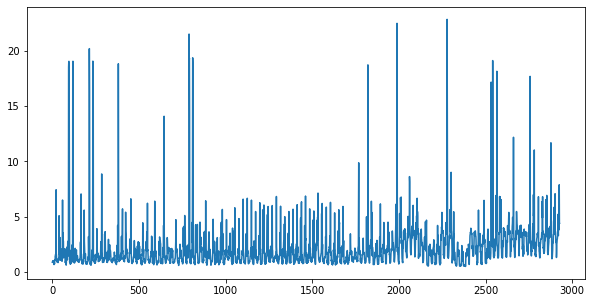

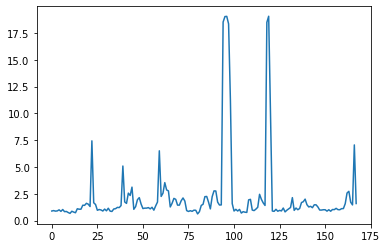

In [7]:
plt.figure(figsize=(10,5))
plt.plot(data['Usage (kilowatt-hours)'])
plt.show()

# close up on the first week
plt.plot(data['Usage (kilowatt-hours)'].head(168))
plt.show()

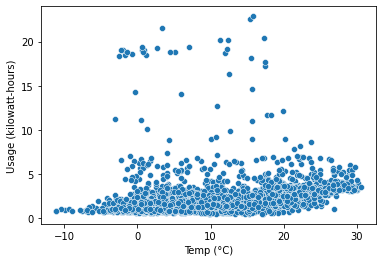

In [8]:
sns.scatterplot(data=data, x="Temp (°C)", y="Usage (kilowatt-hours)")

Hour of the day

In [9]:
data['Time'] = data['Time'].apply(lambda s: float(s.split(':')[0]))

data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours)
0,2020,3,1,0.0,-9.9,-12.3,83,23.0,12,24.1,98.52,NaN,0.89
1,2020,3,1,1.0,-7.0,-11.0,73,25.0,11,24.1,98.54,Clear,0.93
2,2020,3,1,2.0,-7.6,-11.3,75,26.0,10,24.1,98.57,Clear,0.88
3,2020,3,1,3.0,-7.9,-11.0,79,25.0,10,24.1,98.60,Clear,0.90
4,2020,3,1,4.0,-9.4,-11.5,85,26.0,7,24.1,98.63,Clear,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2020,6,30,19.0,26.8,14.1,45,12.0,8,24.1,98.17,Mainly Clear,3.81
2924,2020,6,30,20.0,24.4,15.7,58,17.0,6,24.1,98.20,Mainly Clear,4.64
2925,2020,6,30,21.0,21.4,16.3,72,9.0,5,24.1,98.25,Mainly Clear,7.89
2926,2020,6,30,22.0,21.2,16.8,76,23.0,7,24.1,98.28,Mainly Clear,4.49


Day of Week ( 1 ~ 7 for Mon ~ Sun)

In [10]:
# 2020.3.1 Sunday, 2020.6.30 Tuesday

day_week = []
counter = 0

for day in range(len(data)):
  if 0<= counter <= 23:
    day_week.append(7)
  elif 24 <= counter <=47:
    day_week.append(1)
  elif 48<= counter <= 71:
    day_week.append(2)
  elif 72 <= counter <= 95:
    day_week.append(3)
  elif 96 <= counter <=119:
    day_week.append(4)
  elif 120 <=counter <= 143:
    day_week.append(5)
  elif 144 <= counter <=167:
    day_week.append(6)
  
  counter += 1

  if counter > 167:
    counter = 0

day_week = pd.DataFrame(data=day_week, columns=['day_week'])
day_week

data = pd.concat([data, day_week], axis=1)

,day_week
0,7
1,7
2,7
3,7
4,7
...,...
2923,2
2924,2
2925,2
2926,2


Usage at previous timesteps as features

In [11]:
# past 6hs usage
steps = 7

for i in range(1,steps):
  data['Previous_Usage' + str(i)] = data['Usage (kilowatt-hours)'].shift(i)
  
for i in range(steps-1):
  data.drop(index=i, inplace=True)

data = pd.DataFrame.reset_index(data, drop=True)
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours),day_week,Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6
0,2020,3,1,6.0,-10.4,-11.7,91,21.0,4,24.1,98.65,Clear,1.03,7,0.86,1.00,0.90,0.88,0.93,0.89
1,2020,3,1,7.0,-11.1,-12.2,91,21.0,4,24.1,98.65,Mainly Clear,0.83,7,1.03,0.86,1.00,0.90,0.88,0.93
2,2020,3,1,8.0,-11.1,-12.6,89,19.0,4,24.1,98.69,Mainly Clear,0.85,7,0.83,1.03,0.86,1.00,0.90,0.88
3,2020,3,1,9.0,-4.7,-9.9,67,20.0,13,24.1,98.62,Mainly Clear,0.75,7,0.85,0.83,1.03,0.86,1.00,0.90
4,2020,3,1,10.0,-2.8,-10.1,58,19.0,13,24.1,98.61,Mostly Cloudy,0.67,7,0.75,0.85,0.83,1.03,0.86,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2020,6,30,19.0,26.8,14.1,45,12.0,8,24.1,98.17,Mainly Clear,3.81,2,3.92,4.99,3.29,3.43,3.77,5.21
2918,2020,6,30,20.0,24.4,15.7,58,17.0,6,24.1,98.20,Mainly Clear,4.64,2,3.81,3.92,4.99,3.29,3.43,3.77
2919,2020,6,30,21.0,21.4,16.3,72,9.0,5,24.1,98.25,Mainly Clear,7.89,2,4.64,3.81,3.92,4.99,3.29,3.43
2920,2020,6,30,22.0,21.2,16.8,76,23.0,7,24.1,98.28,Mainly Clear,4.49,2,7.89,4.64,3.81,3.92,4.99,3.29


Season Feature





In [12]:
season = []
for month in data['Month']:
  if 4 <= month <= 5:
    season.append(1)
  elif 6 <= month <= 9:
    season.append(2)
  elif 10 <= month <= 11:
    season.append(3)
  elif 12 == month or month <= 3:
    season.append(4)

season = pd.DataFrame(data=season, columns=['Season'])
season

data = pd.concat([data, season], axis=1)

,Season
0,4
1,4
2,4
3,4
4,4
...,...
2917,2
2918,2
2919,2
2920,2


Unit Circle Mapping for Cyclical Features

In [13]:
def encode_cyclical(data, col, max_val):
  data[col + '_sin'] = np.sin(2*np.pi*data[col]/max_val)
  data[col + '_cos'] = np.cos(2*np.pi*data[col]/max_val)

  data.drop(columns=[col], inplace=True)
  return data


data = encode_cyclical(data, 'Month', 12)
data = encode_cyclical(data, 'Time', 24)
data = encode_cyclical(data, 'Season', 4)
data = encode_cyclical(data, 'day_week', 7)

In [14]:
data_onehot = data.copy()

# Discard features
data_onehot = data_onehot.drop(columns=['Weather', 'Year', 'Day'], axis=1)

data_onehot

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Usage (kilowatt-hours),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,Season_sin,Season_cos,day_week_sin,day_week_cos
0,-10.4,-11.7,91,21.0,4,24.1,98.65,1.03,0.86,1.00,0.90,0.88,0.93,0.89,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.000000
1,-11.1,-12.2,91,21.0,4,24.1,98.65,0.83,1.03,0.86,1.00,0.90,0.88,0.93,1.000000e+00,6.123234e-17,0.965926,-2.588190e-01,-2.449294e-16,1.0,-2.449294e-16,1.000000
2,-11.1,-12.6,89,19.0,4,24.1,98.69,0.85,0.83,1.03,0.86,1.00,0.90,0.88,1.000000e+00,6.123234e-17,0.866025,-5.000000e-01,-2.449294e-16,1.0,-2.449294e-16,1.000000
3,-4.7,-9.9,67,20.0,13,24.1,98.62,0.75,0.85,0.83,1.03,0.86,1.00,0.90,1.000000e+00,6.123234e-17,0.707107,-7.071068e-01,-2.449294e-16,1.0,-2.449294e-16,1.000000
4,-2.8,-10.1,58,19.0,13,24.1,98.61,0.67,0.75,0.85,0.83,1.03,0.86,1.00,1.000000e+00,6.123234e-17,0.500000,-8.660254e-01,-2.449294e-16,1.0,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,26.8,14.1,45,12.0,8,24.1,98.17,3.81,3.92,4.99,3.29,3.43,3.77,5.21,1.224647e-16,-1.000000e+00,-0.965926,2.588190e-01,1.224647e-16,-1.0,9.749279e-01,-0.222521
2918,24.4,15.7,58,17.0,6,24.1,98.20,4.64,3.81,3.92,4.99,3.29,3.43,3.77,1.224647e-16,-1.000000e+00,-0.866025,5.000000e-01,1.224647e-16,-1.0,9.749279e-01,-0.222521
2919,21.4,16.3,72,9.0,5,24.1,98.25,7.89,4.64,3.81,3.92,4.99,3.29,3.43,1.224647e-16,-1.000000e+00,-0.707107,7.071068e-01,1.224647e-16,-1.0,9.749279e-01,-0.222521
2920,21.2,16.8,76,23.0,7,24.1,98.28,4.49,7.89,4.64,3.81,3.92,4.99,3.29,1.224647e-16,-1.000000e+00,-0.500000,8.660254e-01,1.224647e-16,-1.0,9.749279e-01,-0.222521


Data Preprocessing

In [15]:
X_test = data_onehot.drop(columns=['Usage (kilowatt-hours)'], axis=1)
Y_test = data_onehot[['Usage (kilowatt-hours)']]

print(X_test.shape)

# Standardization
scalerX = load('scalerX.joblib')
scalerY = load('scalerY.joblib')

X_test_scaled = scalerX.transform(X_test)
Y_test_scaled = scalerY.transform(Y_test)

X_test_scaled


(2922, 21)


array([[-1.61924700e+00, -1.42042141e+00,  8.10322749e-01, ...,
         1.22957850e+00, -1.51491583e-03,  1.40888311e+00],
       [-1.68156339e+00, -1.46582055e+00,  8.10322749e-01, ...,
         1.22957850e+00, -1.51491583e-03,  1.40888311e+00],
       [-1.68156339e+00, -1.50213986e+00,  6.82402397e-01, ...,
         1.22957850e+00, -1.51491583e-03,  1.40888311e+00],
       ...,
       [ 1.21169732e+00,  1.12193059e+00, -4.04920594e-01, ...,
        -1.22119120e+00,  1.37845009e+00, -3.18527394e-01],
       [ 1.19389264e+00,  1.16732973e+00, -1.49079890e-01, ...,
        -1.22119120e+00,  1.37845009e+00, -3.18527394e-01],
       [ 9.89138805e-01,  1.19456922e+00,  6.82402397e-01, ...,
        -1.22119120e+00,  1.37845009e+00, -3.18527394e-01]])

Load the pre-trained model

In [16]:
model = load_model('FFNN.h5')

model.summary()

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_772 (Dense)            (None, 21)                462       
_________________________________________________________________
dense_773 (Dense)            (None, 30)                660       
_________________________________________________________________
dense_774 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_775 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_776 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_777 (Dense)            (None, 1)                 31        
Total params: 3,943
Trainable params: 3,943
Non-trainable params: 0
__________________________________________________

Accuracy & Evaluation

,predicted,actual
0,0.68,1.03
1,0.67,0.83
2,0.63,0.85
3,0.66,0.75
4,0.70,0.67
...,...,...
2917,3.10,3.81
2918,3.26,4.64
2919,3.75,7.89
2920,5.90,4.49


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

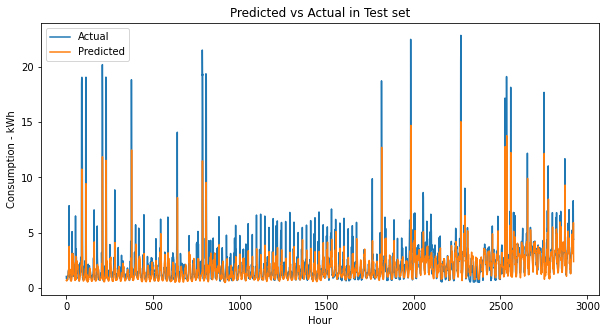

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

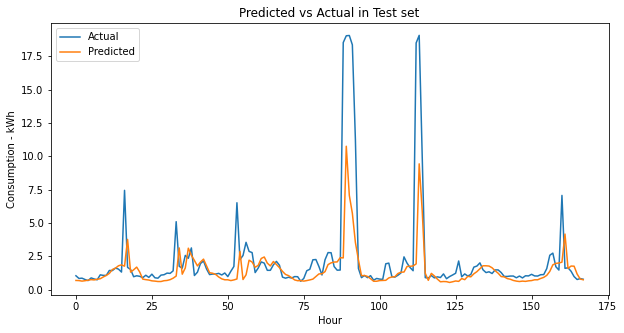

In [17]:
# test set performance
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_test_pred = scalerY.inverse_transform(Y_test_pred_scaled)

# copy the DataFrame indexes
test_results = X_test.copy()
test_results["predicted"] = Y_test_pred
test_results["actual"] = Y_test
test_results = test_results[['predicted', 'actual']]
test_results['predicted'] = test_results['predicted'].round(2)
test_results

# reset the index of DataFrame and use the default indexing (0 1 2 3...N-1)
test_results = pd.DataFrame.reset_index(test_results, drop=True)

# visualize predicted vs actual in test set
plt.figure(figsize=(10,5))
plt.plot(test_results['actual'], label='Actual')
plt.plot(test_results['predicted'], label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_results['actual'].head(168), label='Actual')
plt.plot(test_results['predicted'].head(168), label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

In [18]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

In [19]:
# Error Metric summary
model_performance = pd.DataFrame(columns=['Test MAE', 'Test MAPE', 'Test RMSE'])

Test_MAE = mean_absolute_error(Y_test, Y_test_pred)
Test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
Test_MAPE = mape(Y_test, Y_test_pred).numpy()

model_performance = model_performance.append({
                        'Test MAE': Test_MAE,
                        'Test MAPE': Test_MAPE,
                        'Test RMSE': Test_RMSE},
                        ignore_index=True)

model_performance.round(2)

,Test MAE,Test MAPE,Test RMSE
0,0.77,31.63,1.75
